### Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt

In [50]:
neonatal_df = pd.read_excel('Data 2021-02-27 15-23.xlsx')

In [40]:
neonatal_df.rename(columns={'WHO Region':'region','World Bank Income Group':'income_group', 'Country ISO Code':'country_code'}, inplace=True)

### EDA

In [4]:
neonatal_df.describe()

,Year,Sex,Global,Value
count,30000.00000,0.0,0.0,30000.000000
mean,2008.49660,NaN,NaN,1327.957963
std,5.18996,NaN,NaN,11348.006928
min,2000.00000,NaN,NaN,0.000000
25%,2004.00000,NaN,NaN,0.000000
50%,2008.00000,NaN,NaN,9.178362
75%,2013.00000,NaN,NaN,192.601105
max,2017.00000,NaN,NaN,403786.875000


<AxesSubplot:>

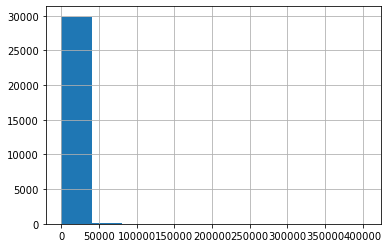

In [5]:
neonatal_df['Value'].hist()

In [6]:
neonatal_df['region'].value_counts()

Africa                   8316
Europe                   8064
Americas                 5796
Western Pacific          3288
Eastern Mediterranean    2772
South-East Asia          1764
Name: region, dtype: int64

In [7]:
neonatal_df['income_group'].value_counts()

Upper middle income    9336
High income            8568
Lower middle income    7056
Low income             5040
Name: income_group, dtype: int64

### Data Preparation

In [41]:
neonatal_df.drop(columns = ['Country', 'Sex', 'Global', 'Age Group'], inplace=True)
neonatal_df = neonatal_df.dropna()

In [42]:
#Label Encoding on country code column
neonatal_df['country_code'] = neonatal_df['country_code'].astype('category')
neonatal_df['country_code_cat'] = neonatal_df['country_code'].cat.codes

There are 120 unique country codes, so i tried three methods for creating dummies for this column:
1. Label Encoding
2. OnehotEncoding
3. MeanEncoding

In [45]:
#Label Encoding for Region, Cause and Income Group
neonatal_df['region'] = neonatal_df['region'].astype('category')
neonatal_df['region_cat'] = neonatal_df['region'].cat.codes
neonatal_df['Cause'] = neonatal_df['Cause'].astype('category')
neonatal_df['cause_cat'] = neonatal_df['Cause'].cat.codes#This is my Target Variable
neonatal_df['income_group'] = neonatal_df['income_group'].astype('category')
neonatal_df['income_group_cat'] = neonatal_df['income_group'].cat.codes

In [47]:
#OneHotEncoding on country_code column
oe_style = OneHotEncoder()
oe_results = oe_style.fit_transform(neonatal_df[["country_code"]])
temp_df = pd.DataFrame(oe_results.toarray(), columns=oe_style.categories_)
for col in temp_df.columns:
    neonatal_df[col]=temp_df[col]

In [44]:
'''Mean Encoding on country_code column, this was implemented 
 to capture information within labels or categories, rendering more predictive features.'''

country_encd_mean = neonatal_df.groupby('country_code')['Value'].mean()
neonatal_df['country_encd_mean'] = neonatal_df['country_code'].map(country_encd_mean)
neonatal_df[['country_code', 'country_encd_mean']].head()

,country_code,country_encd_mean
0,AFG,3961.924645
1,AFG,3961.924645
2,AFG,3961.924645
3,AFG,3961.924645
4,AFG,3961.924645


### Correlation

<AxesSubplot:>

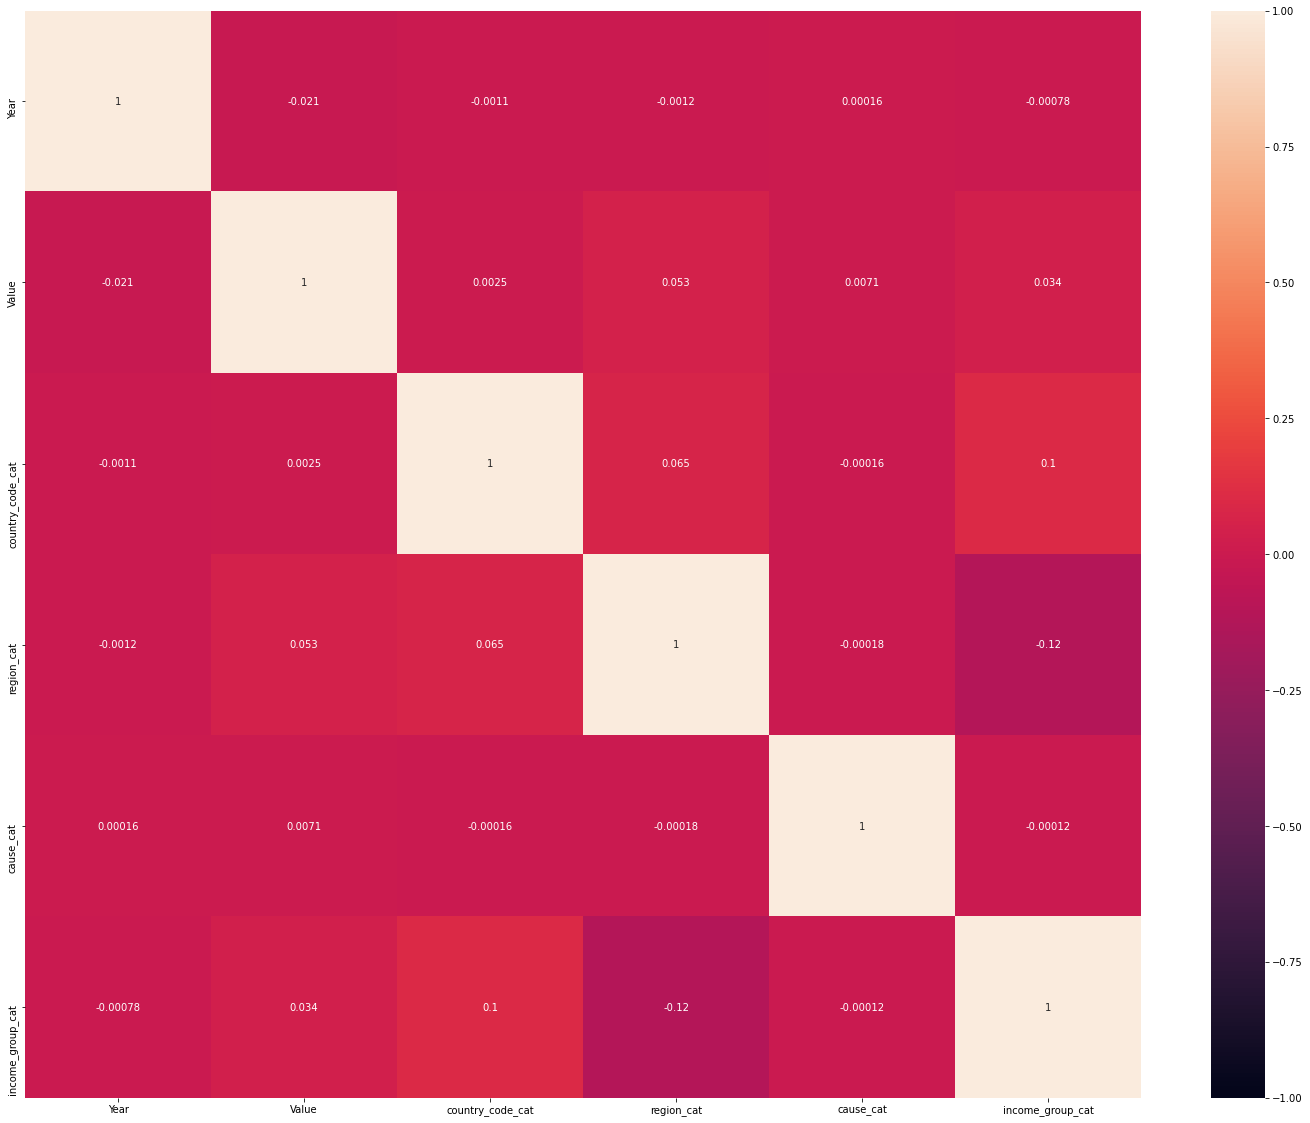

In [46]:

plt.figure(figsize=(25, 20))
sns.heatmap(neonatal_df.corr(), vmin=-1, vmax=1, annot=True)


### Feature Dataframe Creation

In [14]:
feature_cols_label_encdng = ['Value','region_cat', 'income_group_cat', 'country_code_cat']
feature_cols_onehot = [col for col in neonatal_df.columns if col not in ['region', 
                                                                       'income_group',
                                                                       'country_code',
                                                                       'Cause',
                                                                       'cause_cat',
                                                                       'country_code_cat'
                                                                       'country_encd_mean'
                                                                      ]]
feature_cols_mean_encodng = ['Value','region_cat', 'income_group_cat', 'country_encd_mean']



Feature Dataframe with Label Encoded Columns

In [15]:
feature_df_label = neonatal_df[feature_cols_label_encdng]
feature_df_label

,Value,region_cat,income_group_cat,country_code_cat
0,4356.749023,2,1,0
1,15645.974609,2,1,0
2,2904.053467,2,1,0
3,654.522766,2,1,0
4,0.000000,2,1,0
...,...,...,...,...
29995,0.000000,5,3,115
29996,0.000000,5,3,115
29997,0.240370,5,3,115
29998,0.003885,5,3,115


Fature DataFrame with OnehotEncoded Categroical Column

In [16]:
feature_df_onehot = neonatal_df[feature_cols_onehot]
feature_df_onehot

C:\Users\cheta\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


,Year,Value,country_code_cat,region_cat,income_group_cat,"(AFG,)","(AGO,)","(ALB,)","(AND,)","(ARG,)",...,"(MUS,)","(MWI,)","(MYS,)","(NAM,)","(NRU,)","(PRK,)","(SLV,)","(SWZ,)","(TCD,)",country_encd_mean
0,2000.0,4356.749023,0,2,1,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3961.924645
1,2000.0,15645.974609,0,2,1,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3961.924645
2,2000.0,2904.053467,0,2,1,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3961.924645
3,2000.0,654.522766,0,2,1,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3961.924645
4,2000.0,0.000000,0,2,1,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3961.924645
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,2000.0,0.000000,115,5,3,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.362967
29996,2000.0,0.000000,115,5,3,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.362967
29997,2000.0,0.240370,115,5,3,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.362967
29998,2000.0,0.003885,115,5,3,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.362967


Feature DataFrame with Country encoded via Mean Encoding

In [17]:
feature_df_mean = neonatal_df[feature_cols_mean_encodng]
feature_df_mean

,Value,region_cat,income_group_cat,country_encd_mean
0,4356.749023,2,1,3961.924645
1,15645.974609,2,1,3961.924645
2,2904.053467,2,1,3961.924645
3,654.522766,2,1,3961.924645
4,0.000000,2,1,3961.924645
...,...,...,...,...
29995,0.000000,5,3,0.362967
29996,0.000000,5,3,0.362967
29997,0.240370,5,3,0.362967
29998,0.003885,5,3,0.362967


### KNN Classification

#### Without Scaling

##### On Label Encoded Data

In [18]:
x_train, x_test, y_train, y_test = train_test_split(feature_df_label,
                                                          neonatal_df['cause_cat'],
                                                          test_size=0.3,
                                                          random_state=50)\
#Create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=5)

#Train the model using the training sets
knn.fit(x_train, y_train)
train_pred = knn.predict(x_train)
y_pred = knn.predict(x_test)
# print("Train Accuracy", metrics.accuracy_score(y_train, train_pred))
# print("Test Accuracy", metrics.accuracy_score(y_test, y_pred))
# pd.DataFrame(confusion_matrix(y_test, y_pred))
acc_uns_lbl = metrics.accuracy_score(y_test, y_pred)
f1_score_uns_lbl = metrics.f1_score(y_test, y_pred, average='macro')
recall_score_uns_lbl = metrics.recall_score(y_test, y_pred, average='macro')
precision_score_uns_lbl = metrics.precision_score(y_test, y_pred, average='macro')
acc_uns_lbl,f1_score_uns_lbl, recall_score_uns_lbl, precision_score_uns_lbl

(0.38866666666666666,
 0.3872247195870629,
 0.3894412888170187,
 0.39578061143900717)

##### On OneHot Encoded Data

In [19]:
x_train, x_test, y_train, y_test = train_test_split(feature_df_onehot,
                                                          neonatal_df['cause_cat'],
                                                          test_size=0.3,
                                                          random_state=50)
#Create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=5)

#Train the model using the training sets
knn.fit(x_train, y_train)
train_pred = knn.predict(x_train)
y_pred = knn.predict(x_test)
# print("Train Accuracy", metrics.accuracy_score(y_train, train_pred))
# print("Test Accuracy", metrics.accuracy_score(y_test, y_pred))
pd.DataFrame(confusion_matrix(y_test, y_pred))

acc_uns_ohe = metrics.accuracy_score(y_test, y_pred)
f1_score_uns_ohe = metrics.f1_score(y_test, y_pred, average='macro')
recall_score_uns_ohe = metrics.recall_score(y_test, y_pred, average='macro')
precision_score_uns_ohe = metrics.precision_score(y_test, y_pred, average='macro')

acc_uns_ohe,f1_score_uns_ohe, recall_score_uns_ohe, precision_score_uns_ohe

(0.4242222222222222,
 0.4281899804747124,
 0.42371179933144365,
 0.4541614703231968)

##### On MeanEncoded Data

In [20]:
x_train, x_test, y_train, y_test = train_test_split(feature_df_mean,
                                                          neonatal_df['cause_cat'],
                                                          test_size=0.3,
                                                          random_state=50)\
#Create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=5)

#Train the model using the training sets
knn.fit(x_train, y_train)
train_pred = knn.predict(x_train)
y_pred = knn.predict(x_test)
# print("Train Accuracy", metrics.accuracy_score(y_train, train_pred))
# print("Test Accuracy", metrics.accuracy_score(y_test, y_pred))
pd.DataFrame(confusion_matrix(y_test, y_pred))
acc_uns_mne = metrics.accuracy_score(y_test, y_pred)
f1_score_uns_mne = metrics.f1_score(y_test, y_pred, average='macro')
recall_score_uns_mne = metrics.recall_score(y_test, y_pred, average='macro')
precision_score_uns_mne = metrics.precision_score(y_test, y_pred, average='macro')

acc_uns_mne,f1_score_uns_mne, recall_score_uns_mne, precision_score_uns_mne

(0.4988888888888889, 0.495797026545249, 0.4986781888911546, 0.5006143695228038)

#### With Scaled Data

In [21]:
scaler = StandardScaler()
scaler.fit(neonatal_df['Value'].values.reshape(-1,1))
X = scaler.transform(neonatal_df['Value'].values.reshape(-1,1))


##### On Label Encoded Data

In [22]:
feature_df_label['values_scaled'] = X
feature_df_label_new = feature_df_label[feature_df_label.columns[1:]]
x_train, x_test, y_train, y_test = train_test_split(feature_df_label_new,
                                                          neonatal_df['cause_cat'],
                                                          test_size=0.3,
                                                          random_state=50)\
#Create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=5)

#Train the model using the training sets
knn.fit(x_train, y_train)
train_pred = knn.predict(x_train)
y_pred = knn.predict(x_test)
print("Train Accuracy", metrics.accuracy_score(y_train, train_pred))
print("Test Accuracy", metrics.accuracy_score(y_test, y_pred))
pd.DataFrame(confusion_matrix(y_test, y_pred))
acc_uns_lbl_en = metrics.accuracy_score(y_test, y_pred)
f1_score_uns_lbl_en = metrics.f1_score(y_test, y_pred, average='macro')
recall_score_uns_lbl_en = metrics.recall_score(y_test, y_pred, average='macro')
precision_score_uns_lbl_en = metrics.precision_score(y_test, y_pred, average='macro')

acc_uns_lbl_en,f1_score_uns_lbl_en, recall_score_uns_lbl_en, precision_score_uns_lbl_en

<ipython-input-22-676ce23dbe4d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_df_label['values_scaled'] = X


Train Accuracy 0.6048571428571429
Test Accuracy 0.5197777777777778


(0.5197777777777778,
 0.5182399312167318,
 0.5201089894952005,
 0.5305985594829169)

##### On OneHot Encoded Data

In [24]:
feature_df_onehot['values_scaled'] = X
feature_df_onehot_new = feature_df_onehot[feature_df_onehot.columns[1:]]
x_train, x_test, y_train, y_test = train_test_split(feature_df_onehot_new,
                                                          neonatal_df['cause_cat'],
                                                          test_size=0.3,
                                                          random_state=50)\
#Create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=5)

#Train the model using the training sets
knn.fit(x_train, y_train)
train_pred = knn.predict(x_train)
y_pred = knn.predict(x_test)
print("Train Accuracy", metrics.accuracy_score(y_train, train_pred))
print("Test Accuracy", metrics.accuracy_score(y_test, y_pred))
pd.DataFrame(confusion_matrix(y_test, y_pred))
acc_uns_ohe_sc = metrics.accuracy_score(y_test, y_pred)
f1_score_uns_ohe_sc = metrics.f1_score(y_test, y_pred, average='macro')
recall_score_uns_ohe_sc = metrics.recall_score(y_test, y_pred, average='macro')
precision_score_uns_ohe_sc = metrics.precision_score(y_test, y_pred, average='macro')

acc_uns_ohe_sc,f1_score_uns_ohe_sc, recall_score_uns_ohe_sc, precision_score_uns_ohe_sc

<ipython-input-24-3dd0a4acff8c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_df_onehot['values_scaled'] = X


Train Accuracy 0.5927142857142857
Test Accuracy 0.5114444444444445


(0.5114444444444445, 0.509786897728635, 0.511467753833105, 0.5144697621385418)

##### On MeanEncoded Data

In [25]:
feature_df_mean['values_scaled'] = X
feature_df_mean_new = feature_df_mean[feature_df_mean.columns[1:]]
x_train, x_test, y_train, y_test = train_test_split(feature_df_mean_new,
                                                          neonatal_df['cause_cat'],
                                                          test_size=0.3,
                                                          random_state=50)\
#Create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=5)

#Train the model using the training sets
knn.fit(x_train, y_train)
train_pred = knn.predict(x_train)
y_pred = knn.predict(x_test)
print("Train Accuracy", metrics.accuracy_score(y_train, train_pred))
print("Test Accuracy", metrics.accuracy_score(y_test, y_pred))
pd.DataFrame(confusion_matrix(y_test, y_pred))
acc_uns_mne_sc = metrics.accuracy_score(y_test, y_pred)
f1_score_uns_mne_sc = metrics.f1_score(y_test, y_pred, average='macro')
recall_score_uns_mne_sc = metrics.recall_score(y_test, y_pred, average='macro')
precision_score_uns_mne_sc = metrics.precision_score(y_test, y_pred, average='macro')

acc_uns_mne_sc,f1_score_uns_mne_sc, recall_score_uns_mne_sc, precision_score_uns_mne_sc

<ipython-input-25-b69be1dd187a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_df_mean['values_scaled'] = X


Train Accuracy 0.6044761904761905
Test Accuracy 0.5208888888888888


(0.5208888888888888, 0.5187042545121984, 0.520888933690636, 0.5258915832309973)

### Combined Results

In [36]:
results_array = np.array([acc_uns_lbl,f1_score_uns_lbl, recall_score_uns_lbl, precision_score_uns_lbl,
acc_uns_ohe,f1_score_uns_ohe, recall_score_uns_ohe, precision_score_uns_ohe,
acc_uns_mne,f1_score_uns_mne, recall_score_uns_mne, precision_score_uns_mne,
acc_uns_lbl_en,f1_score_uns_lbl_en, recall_score_uns_lbl_en, precision_score_uns_lbl_en,
acc_uns_ohe_sc,f1_score_uns_ohe_sc, recall_score_uns_ohe_sc, precision_score_uns_ohe_sc,
acc_uns_mne_sc,f1_score_uns_mne_sc, recall_score_uns_mne_sc, precision_score_uns_mne_sc]).reshape(6,4)

results_df = pd.DataFrame(results_array, columns = ['Accuracy', 'F1 Score', 'Recall', 'Precision'], index=['Label Encoded', 'OneHot Encoded', 'MeanEncoded', 'Label Encoded Scaled', 'OneHot Encoded Scaled', 'MeanEncoded Scaled'])

In [37]:
results_df

,Accuracy,F1 Score,Recall,Precision
Label Encoded,0.388667,0.387225,0.389441,0.395781
OneHot Encoded,0.424222,0.428190,0.423712,0.454161
MeanEncoded,0.498889,0.495797,0.498678,0.500614
Label Encoded Scaled,0.519778,0.518240,0.520109,0.530599
OneHot Encoded Scaled,0.511444,0.509787,0.511468,0.514470
MeanEncoded Scaled,0.520889,0.518704,0.520889,0.525892


### Random Forest 

#### Mean Encoded Data

In [48]:
feature_df_mean['values_scaled'] = X
feature_df_mean_new = feature_df_mean[feature_df_mean.columns[1:]]

In [ ]:
feature_df_mean_new

In [49]:

x_train, x_test, y_train, y_test = train_test_split(feature_df_mean_new,
                                                          neonatal_df['cause_cat'],
                                                          test_size=0.3,
                                                          random_state=50)
model = RandomForestClassifier(n_estimators=1000, 
                               random_state=50)

# Fit on training data
model.fit(x_train, y_train)


n_nodes = []
max_depths = []

# Stats about the trees in random forest
for ind_tree in model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

# Training predictions (to demonstrate overfitting)
train_rf_predictions = model.predict(x_train)
print("Training Accuracy",metrics.accuracy_score(y_train, train_rf_predictions))
#
y_pred_rf = model.predict(x_test)
# rf_probs = model.predict_proba(test)[:, 1]
print("Test Accuracy",metrics.accuracy_score(y_test, y_pred_rf))

Average number of nodes 8586
Average maximum depth 27
Training Accuracy 0.77
Test Accuracy 0.46444444444444444
